## Multilabel 

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras as K
import matplotlib.cm as cm
from tqdm import tqdm
from pathlib import Path
from keras import backend as K
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from tensorflow import keras
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import TensorBoard
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Prepare Dataset

In [2]:
df = pd.read_csv('data/label.csv')
df

,Filename,Label
0,image_1.jpg,"[Kerbau,Manusia]"
1,image_10.jpg,"[Kerbau,Manusia]"
2,image_100.jpg,[Kerbau]
3,image_101.jpg,"[Kerbau,Manusia]"
4,image_102.jpg,"[Kerbau,Manusia]"
...,...,...
2110,image_1999.jpg,"[Kerbau,Manusia,Truk]"
2111,image_2.jpg,"[Kerbau,Manusia]"
2112,image_20.jpg,"[Kerbau,Manusia]"
2113,image_200.jpg,[Kerbau]


In [3]:
# buat daftar unique dari semua label
unique_label = set()
for label in df["Label"]:
    label_list = label.strip("[]").split(",")
    for label in label_list:
        unique_label.add(label.strip())

unique_label = sorted(list(unique_label))
# buatkan kolom one-hot encodinf setiap label
for label in unique_label:
    df[label] = df["Label"].apply(lambda x: int(label in x))

In [4]:
df.head()

,Filename,Label,Hewan liar,Kerbau,Manusia,Motor,Truk
0,image_1.jpg,"[Kerbau,Manusia]",0,1,1,0,0
1,image_10.jpg,"[Kerbau,Manusia]",0,1,1,0,0
2,image_100.jpg,[Kerbau],0,1,0,0,0
3,image_101.jpg,"[Kerbau,Manusia]",0,1,1,0,0
4,image_102.jpg,"[Kerbau,Manusia]",0,1,1,0,0


In [5]:
len(df)

2115

In [6]:
df["Filename"] = "data/image/" + df["Filename"] 

<Axes: xlabel='Label'>

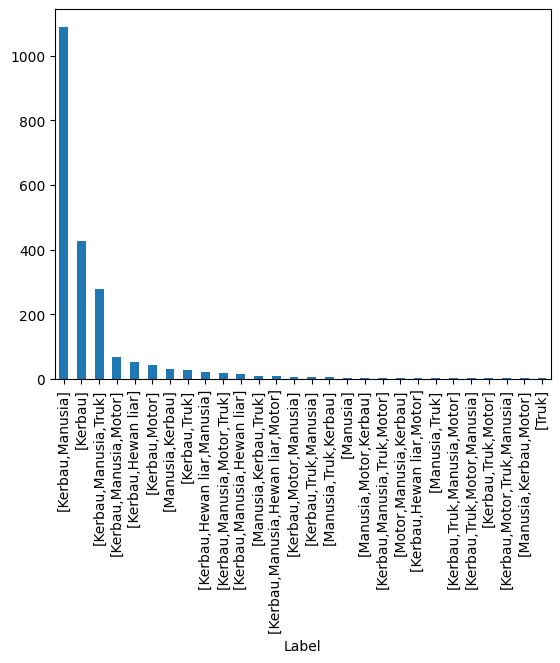

In [7]:
df['Label'].value_counts().plot(kind='bar')

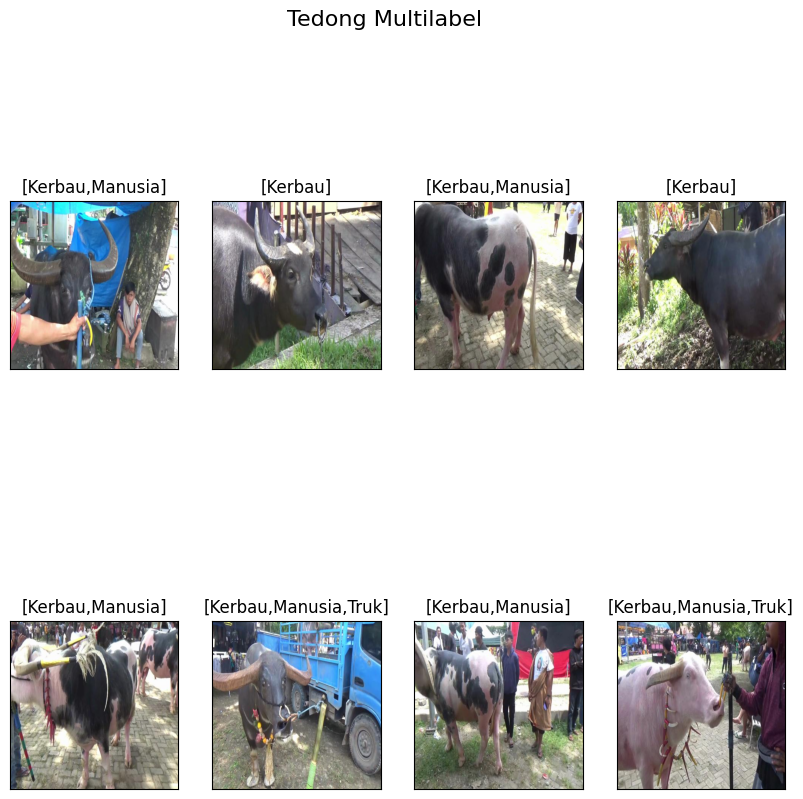

In [8]:
random_index = np.random.randint(0, len(df), 10)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filename[random_index[i]]))
    ax.set_title(df.Label[random_index[i]])
fig.suptitle("Tedong Multilabel", fontsize=16)
plt.show()
fig.savefig("tedong.png")

In [9]:
# df.drop(columns='Label', axis=1, inplace=True)
# df

In [10]:
train, test = train_test_split(df, test_size=0.05, random_state=42)

In [11]:
train = train.drop(columns="Label", axis=1)
train

,Filename,Hewan liar,Kerbau,Manusia,Motor,Truk
1239,data/image/image_1210.jpg,0,1,1,0,1
1818,data/image/image_1734.jpg,0,1,1,0,1
1630,data/image/image_1563.jpg,0,1,1,0,0
582,data/image/image_573.jpg,0,1,1,0,0
368,data/image/image_430.jpg,1,1,0,0,0
...,...,...,...,...,...,...
1638,data/image/image_1570.jpg,0,1,1,1,0
1095,data/image/image_1081.jpg,0,1,1,0,1
1130,data/image/image_1112.jpg,0,1,1,0,0
1294,data/image/image_1260.jpg,0,1,1,0,1


In [12]:
test = test.drop(columns="Label", axis=1)
test

,Filename,Hewan liar,Kerbau,Manusia,Motor,Truk
1617,data/image/image_1551.jpg,0,1,1,0,0
1471,data/image/image_142.jpg,0,1,1,0,0
259,data/image/image_332.jpg,0,1,1,0,0
432,data/image/image_489.jpg,0,1,0,0,0
1506,data/image/image_1451.jpg,0,1,1,0,0
...,...,...,...,...,...,...
1876,data/image/image_1787.jpg,0,1,1,0,0
1690,data/image/image_1617.jpg,0,1,1,0,0
1709,data/image/image_1634.jpg,0,1,1,0,0
1483,data/image/image_1430.jpg,0,1,1,0,0


In [13]:
classes = ["Hewan liar","Kerbau","Manusia","Motor","Truk"]

In [14]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# The value for class_mode in flow_from_dataframe MUST be 'raw' if you are attempting to do multilabel classification.
train_gen = train_datagen.flow_from_dataframe(train, 
                                            x_col='Filename', 
                                            y_col=classes,
                                            target_size=(224,224),
                                            class_mode='raw',
                                            batch_size=32,
                                            shuffle=True,
                                            subset='training')
val_gen = train_datagen.flow_from_dataframe(train,
                                            x_col='Filename',
                                            y_col=classes,
                                            target_size=(224,224),
                                            class_mode='raw',
                                            batch_size=16,
                                            subset='validation')

Found 1608 validated image filenames.
Found 401 validated image filenames.


In [93]:
test_gen = test_datagen.flow_from_dataframe(test,
                                            x_col='Filename',
                                            y_col=classes,
                                            batch_size=1,
                                            shuffle=None,
                                            seed=42,
                                            target_size=(224,224),
                                            class_mode="raw")

Found 106 validated image filenames.


## Metrics

In [16]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives =K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = ["accuracy", 
           tf.keras.metrics.Recall(),
           tf.keras.metrics.Precision(),
           f1_score]

## Callback

In [17]:
import datetime
def tensorboard_callback(name):
    logdir = os.path.join("Tensorboard/logs", datetime.datetime.now().strftime(f"%Y-%m-%d-{name}"))
    return TensorBoard(logdir)

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.9):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_accuracy") > self.accuracy:
            print(f"\nAkurasi telah mencapai {self.accuracy}%")
            self.model.stop_training = True

## Plot Model

In [18]:
def plot_model(model, name_model):
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,
                                     ncols=1,
                                     figsize=(15, 15))
        ax1.plot(model.history["accuracy"], marker=".")
        ax1.plot(model.history["recall"], marker=".") 
        ax1.plot(model.history["precision"], marker=".")
        ax1.plot(model.history["f1_score"], marker=".")
        ax1.set_xlabel("epochs")
        ax1.legend(["accuracy", 
        "recall", 
        "precission", 
        "f1"], loc="lower left")
        ax1.grid(True)
        ax1.set_title(name_model + ' Training')
        
        ax2.plot(model.history["val_accuracy"], marker=".")
        ax2.plot(model.history["val_recall"], marker=".") 
        ax2.plot(model.history["val_precision"], marker=".")
        ax2.plot(model.history["val_f1_score"], marker=".")
        ax2.set_xlabel("epochs")
        ax2.legend(["val_accuracy", 
                "val_recall", 
                "val_precission", 
                "val_f1"], loc="lower left")
        ax2.grid(True)
        ax2.set_title(name_model + " Val")
        
        ax3.plot(model.history["loss"])
        ax3.plot(model.history["val_loss"])
        ax3.set_xlabel("epochs")
        ax3.legend(["loss", 'val_loss'])
        ax3.grid(True)
        ax3.set_title(name_model + " Loss")
        fig.suptitle(name_model, fontsize=24)
        return plt.show

## Predict

In [19]:
def predict(model, name_file):
    test_gen.reset()
    pred = model.predict(test_gen,steps=test_gen.n // test_gen.batch_size, verbose=1)
    pred_bool = (pred > 0.5)
    predictions = pred_bool.astype(int)
    columns=classes
    #columns should be the same order of y_col
    results = pd.DataFrame(predictions, columns=columns)
    results["Filenames"] = test_gen.filenames
    ordered_cols=["Filenames"]+columns
    results=results[ordered_cols]
    return results.to_csv(name_file, index=False)
    

## visual confusion matrix

In [20]:
y_true = test[classes]

In [21]:
def visaul_confusion_matrix(y_true, y_pred):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    print(mcm)
# Display confusion matrices for each class
    for i in range(len(classes)):
        disp = ConfusionMatrixDisplay(confusion_matrix=mcm[i], display_labels=[0, 1])
        disp.plot(cmap='viridis', values_format='d')
        plt.title(f'Confusion Matrix for {classes[i]}')
    return plt.show()
        

# Model

### Resnet50V2

In [22]:
def resnet():
    pre_trained_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
    
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    return pre_trained_model

In [23]:
resnet = resnet()

In [24]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [25]:
last_layer = resnet.get_layer("post_relu")
last_output = last_layer.output

In [26]:
last_output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'post_relu')>

In [27]:
def model_resnet(pre_trained_model, last_layer):
    x = tf.keras.layers.Flatten()(last_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [28]:
model_resNet50V2 = model_resnet(resnet, last_output)
model_resNet50V2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resNet50V2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block2_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_pad (ZeroPaddin  (None, 58, 58, 64)  0           ['conv2_block2_1_relu[0][0]']    
 g2D)     

In [29]:
with tf.device("/device:GPU:0"):
        histori1 = model_resNet50V2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resNet50V2")])

Epoch 1/30
50/50 [==============================] - 14s 96ms/step - loss: 2.0000 - accuracy: 0.9169 - recall: 0.8603 - precision: 0.8528 - f1_score: 0.8584 - val_loss: 0.3835 - val_accuracy: 0.9075 - val_recall: 0.9221 - val_precision: 0.9267 - val_f1_score: 0.9243
Epoch 2/30
50/50 [==============================] - 3s 69ms/step - loss: 0.2533 - accuracy: 0.8839 - recall: 0.9411 - precision: 0.9411 - f1_score: 0.9417 - val_loss: 0.2335 - val_accuracy: 0.9075 - val_recall: 0.9404 - val_precision: 0.9461 - val_f1_score: 0.9436
Epoch 3/30
50/50 [==============================] - 3s 69ms/step - loss: 0.1158 - accuracy: 0.9105 - recall: 0.9695 - precision: 0.9661 - f1_score: 0.9683 - val_loss: 0.2378 - val_accuracy: 0.9425 - val_recall: 0.9586 - val_precision: 0.9493 - val_f1_score: 0.9537
Epoch 4/30
50/50 [==============================] - 3s 68ms/step - loss: 0.0911 - accuracy: 0.8966 - recall: 0.9808 - precision: 0.9740 - f1_score: 0.9772 - val_loss: 0.2263 - val_accuracy: 0.9225 - val_r

<function matplotlib.pyplot.show(close=None, block=None)>

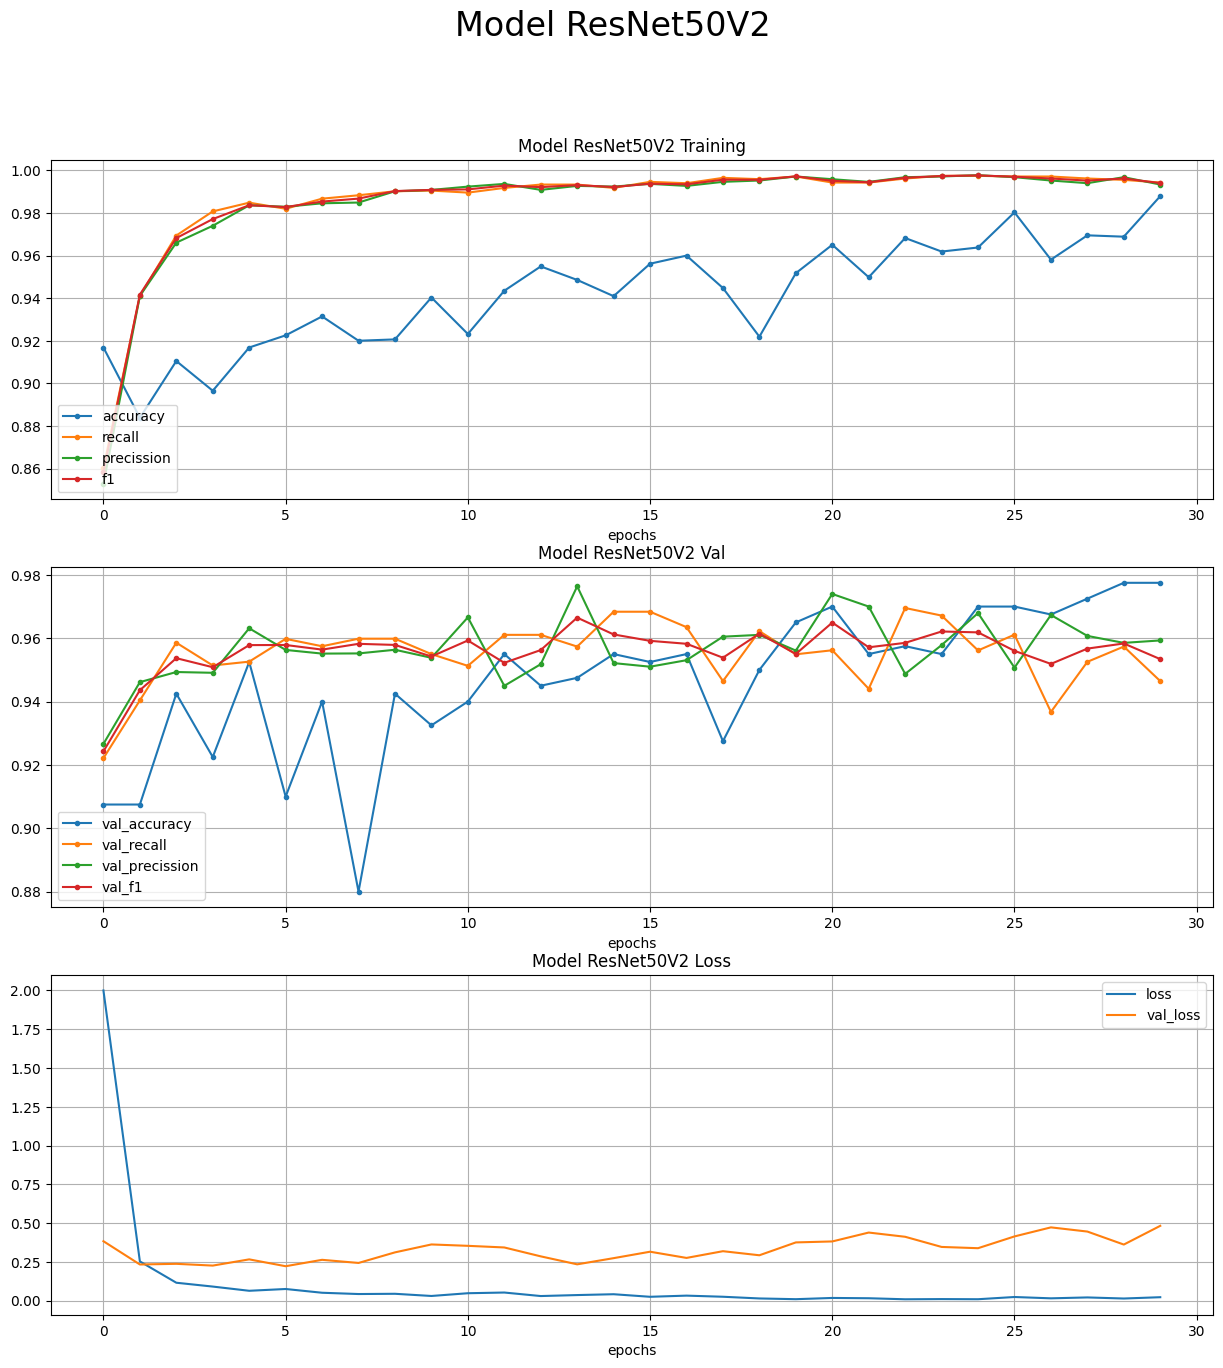

In [30]:
plot_model(histori1, "Model ResNet50V2")

In [97]:
model_resNet50V2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 2s 19ms/step - loss: 0.5374 - accuracy: 0.9906 - recall: 0.9623 - precision: 0.9444 - f1_score: 0.9565


[0.5373843312263489,
 0.9905660152435303,
 0.9622641801834106,
 0.9444444179534912,
 0.9565140604972839]

In [31]:
predict(model_resNet50V2, "model resNet50V2.csv")

106/106 [==============================] - 2s 15ms/step


In [32]:
dt_predict_resnet = pd.read_csv("model resNet50V2.csv")

In [33]:
y_pred_1 = dt_predict_resnet[classes]

[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 26   5]
  [  1  74]]

 [[ 96   1]
  [  1   8]]

 [[ 83   5]
  [  6  12]]]


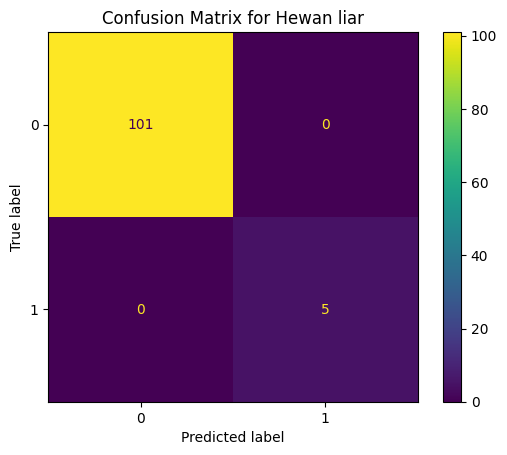

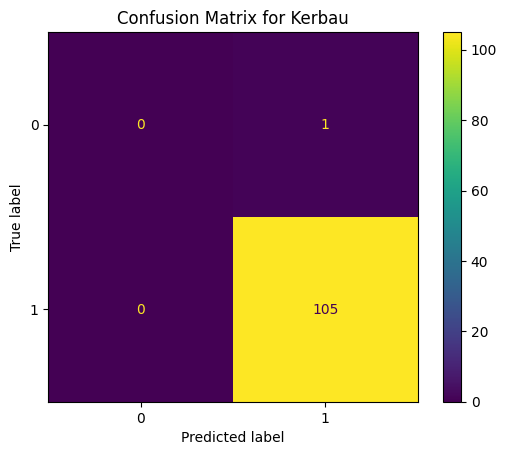

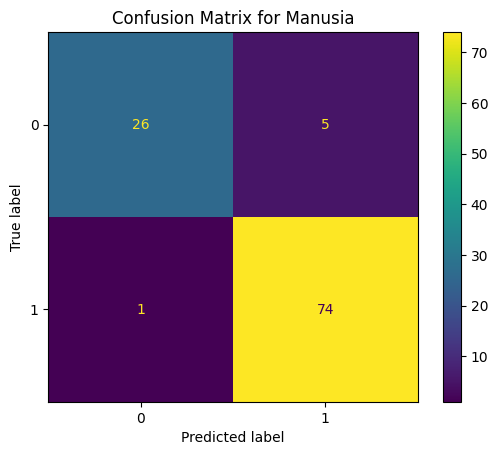

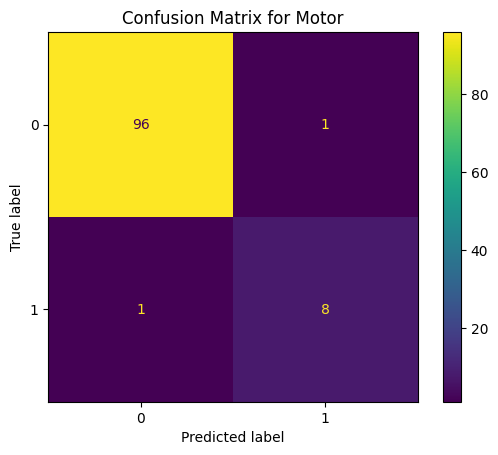

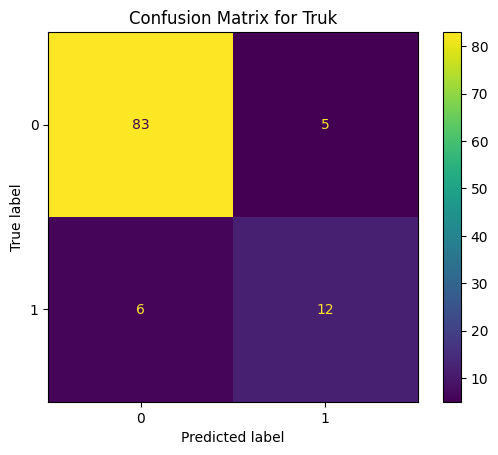

In [34]:
visaul_confusion_matrix(y_true, y_pred_1)

### Resnet101v2

In [35]:
def resnet101v2():
    pre_train = tf.keras.applications.resnet_v2.ResNet101V2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )
    
    for layer in pre_train.layers:
        layer.trainable = False
        
    return pre_train

In [36]:
resnet101v2 = resnet101v2()
resnet101v2.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [37]:
last_layer_2 = resnet101v2.get_layer("post_relu")
last_output_2 = last_layer_2.output

In [38]:
def model_resnet101(pre_trained_model, last_layer):
    x = tf.keras.layers.Flatten()(last_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [39]:
model_resNet101V2 = model_resnet101(resnet101v2, last_output_2)
model_resNet101V2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resNet101V2.summary()

Model: "model_1"


__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 pool1_pad

In [40]:
with tf.device("/device:GPU:0"):
        histori2 = model_resNet101V2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resNet101V2")])

Epoch 1/30
50/50 [==============================] - 11s 107ms/step - loss: 2.3270 - accuracy: 0.9245 - recall: 0.8824 - precision: 0.8775 - f1_score: 0.8620 - val_loss: 0.4010 - val_accuracy: 0.9550 - val_recall: 0.9026 - val_precision: 0.9476 - val_f1_score: 0.9246
Epoch 2/30
50/50 [==============================] - 4s 76ms/step - loss: 0.2453 - accuracy: 0.8934 - recall: 0.9420 - precision: 0.9405 - f1_score: 0.9406 - val_loss: 0.1924 - val_accuracy: 0.9575 - val_recall: 0.9404 - val_precision: 0.9555 - val_f1_score: 0.9474
Epoch 3/30
50/50 [==============================] - 4s 76ms/step - loss: 0.1212 - accuracy: 0.9334 - recall: 0.9675 - precision: 0.9709 - f1_score: 0.9688 - val_loss: 0.1848 - val_accuracy: 0.9475 - val_recall: 0.9440 - val_precision: 0.9510 - val_f1_score: 0.9483
Epoch 4/30
50/50 [==============================] - 4s 76ms/step - loss: 0.0913 - accuracy: 0.9048 - recall: 0.9744 - precision: 0.9760 - f1_score: 0.9751 - val_loss: 0.1890 - val_accuracy: 0.9400 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

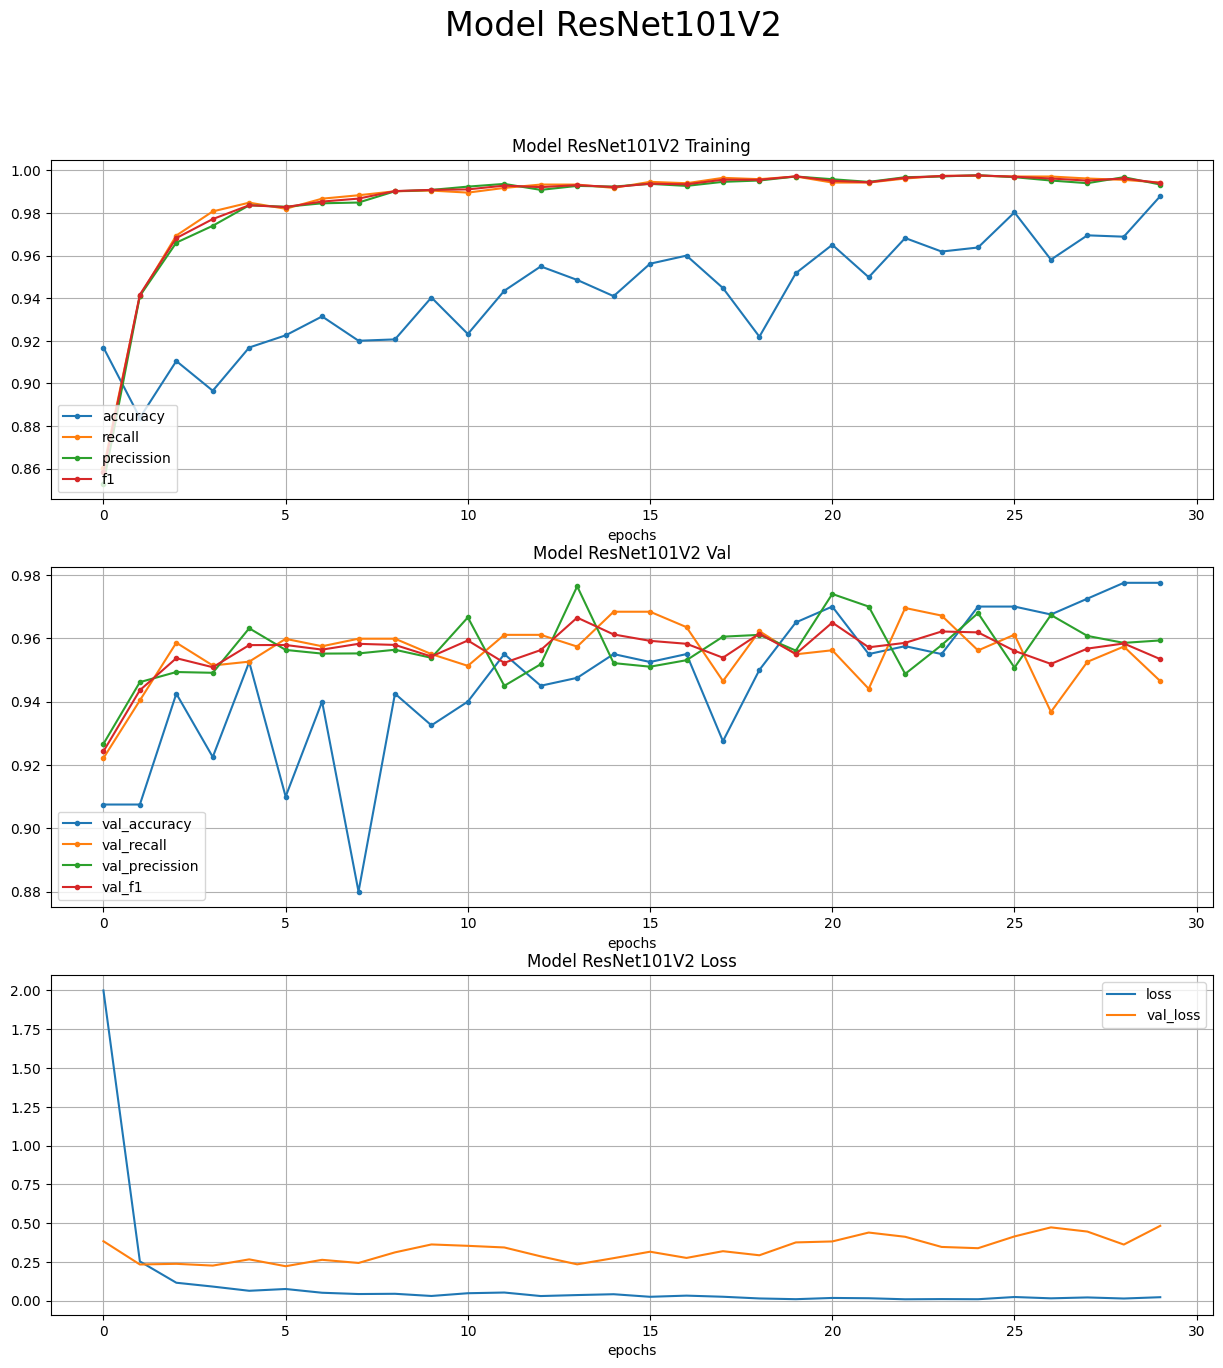

In [41]:
plot_model(histori1, "Model ResNet101V2")

In [98]:
model_resNet101V2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 3s 31ms/step - loss: 0.3701 - accuracy: 0.9906 - recall: 0.9670 - precision: 0.9447 - f1_score: 0.9585


[0.3701168894767761,
 0.9905660152435303,
 0.9669811129570007,
 0.9447004795074463,
 0.9584905505180359]

In [42]:
predict(model_resNet101V2, "model resNet101V2.csv")

106/106 [==============================] - 4s 28ms/step


In [43]:
dt_predict_resnet101 = pd.read_csv("model resNet101V2.csv")

In [44]:
y_pred_2 = dt_predict_resnet101[classes]

[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 27   4]
  [  2  73]]

 [[ 96   1]
  [  1   8]]

 [[ 82   6]
  [  4  14]]]


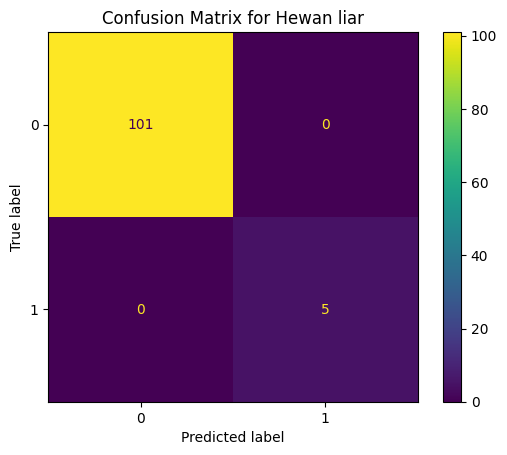

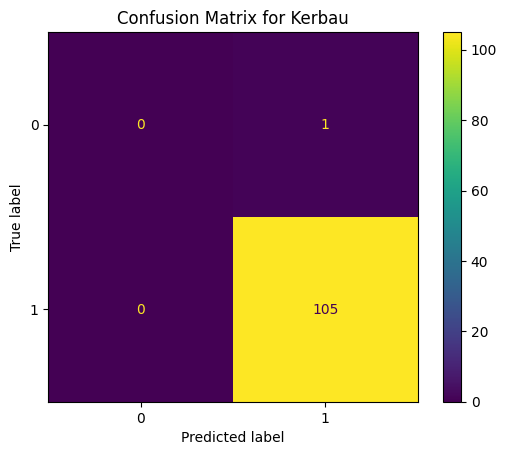

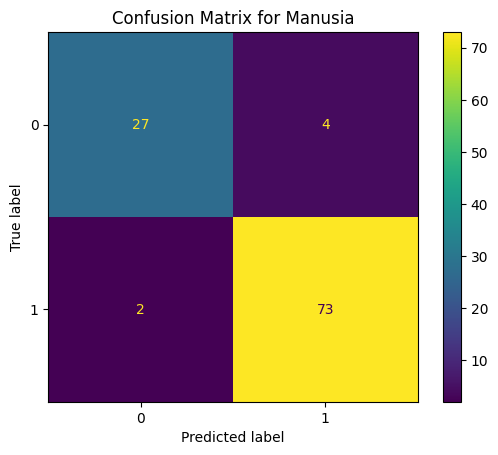

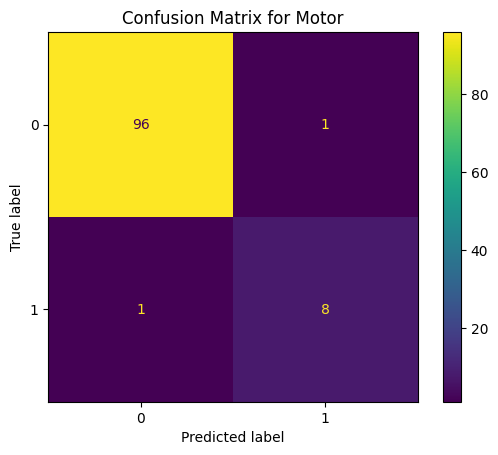

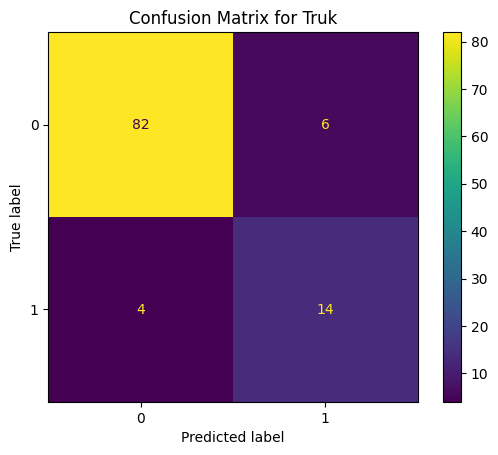

In [45]:
visaul_confusion_matrix(y_true, y_pred_2)

## Resnet152v2

In [46]:
def resnet152v2():
    pre_trained = tf.keras.applications.resnet_v2.ResNet152V2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet"
    )
    
    for layer in pre_trained.layers:
        layer.trainable = False
        
    return pre_trained

In [47]:
resnet152v2 = resnet152v2()
resnet152v2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [48]:
last_layer_3 = resnet152v2.get_layer("post_relu")
last_output_3 = last_layer_3.output

In [49]:
def model_resnet152(pre_trained_model, last_layer):
    x = tf.keras.layers.Flatten()(last_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [50]:
model_resNet152V2 = model_resnet101(resnet152v2, last_output_3)
model_resNet152V2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)
model_resNet152V2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [51]:
with tf.device("/device:GPU:0"):
        histori3 = model_resNet152V2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_resNet152V2")])

Epoch 1/30
50/50 [==============================] - 15s 154ms/step - loss: 2.3299 - accuracy: 0.8845 - recall: 0.8849 - precision: 0.8734 - f1_score: 0.8596 - val_loss: 0.2955 - val_accuracy: 0.8975 - val_recall: 0.9052 - val_precision: 0.9625 - val_f1_score: 0.9334
Epoch 2/30
50/50 [==============================] - 5s 105ms/step - loss: 0.2250 - accuracy: 0.8782 - recall: 0.9462 - precision: 0.9447 - f1_score: 0.9452 - val_loss: 0.2163 - val_accuracy: 0.9150 - val_recall: 0.9380 - val_precision: 0.9542 - val_f1_score: 0.9467
Epoch 3/30
50/50 [==============================] - 5s 105ms/step - loss: 0.1240 - accuracy: 0.8915 - recall: 0.9651 - precision: 0.9629 - f1_score: 0.9639 - val_loss: 0.2138 - val_accuracy: 0.9700 - val_recall: 0.9344 - val_precision: 0.9600 - val_f1_score: 0.9469
Epoch 4/30
50/50 [==============================] - 5s 105ms/step - loss: 0.0758 - accuracy: 0.9105 - recall: 0.9748 - precision: 0.9779 - f1_score: 0.9767 - val_loss: 0.1780 - val_accuracy: 0.9150 - v

<function matplotlib.pyplot.show(close=None, block=None)>

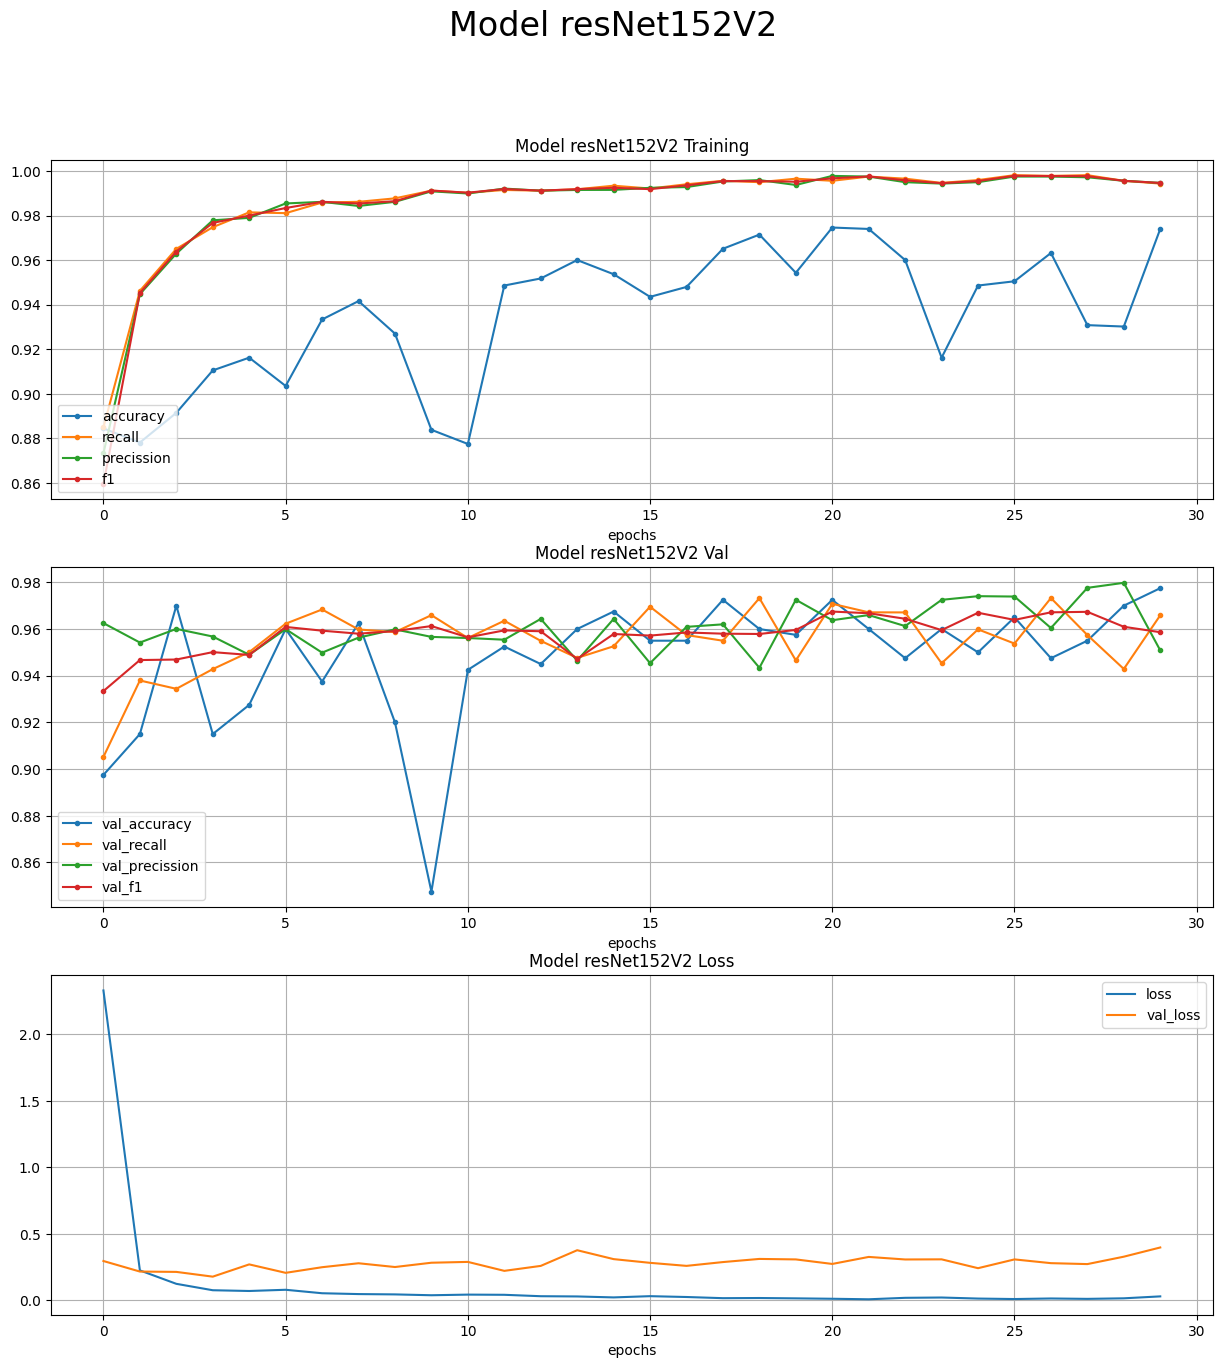

In [52]:
plot_model(histori3, "Model resNet152V2")

In [99]:
model_resNet152V2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 5s 43ms/step - loss: 0.4778 - accuracy: 0.9623 - recall: 0.9575 - precision: 0.9312 - f1_score: 0.9442


[0.4777897596359253,
 0.9622641801834106,
 0.9575471878051758,
 0.9311926364898682,
 0.94424968957901]

In [53]:
predict(model_resNet152V2, "model resNet152V2.csv")

106/106 [==============================] - 6s 35ms/step


In [54]:
dt_predict_resnet152 = pd.read_csv("model resNet152V2.csv")

In [55]:
y_pred_3 = dt_predict_resnet152[classes]

[[[101   0]
  [  0   5]]

 [[  0   1]
  [  0 105]]

 [[ 24   7]
  [  3  72]]

 [[ 96   1]
  [  2   7]]

 [[ 82   6]
  [  4  14]]]


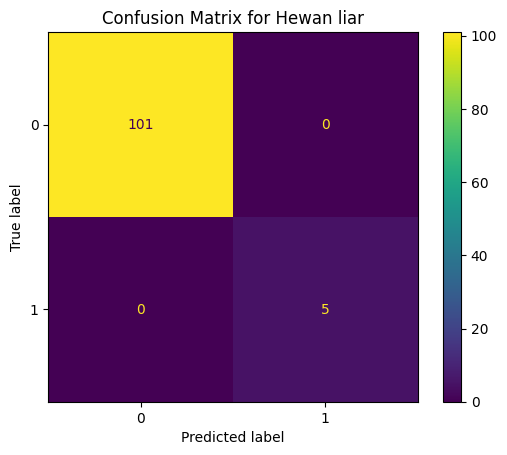

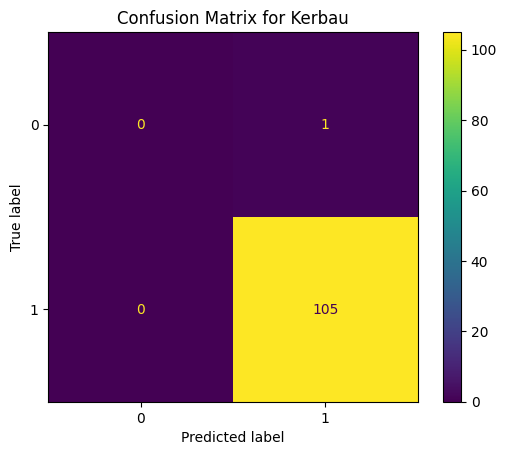

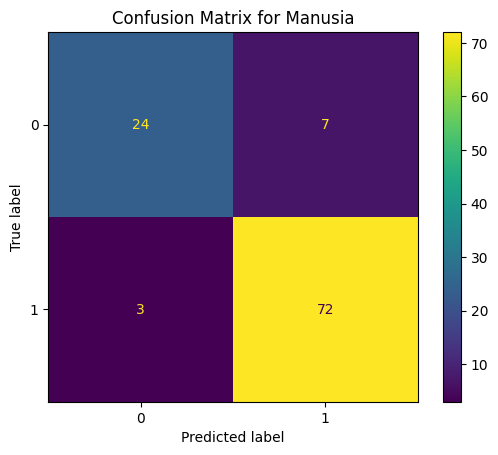

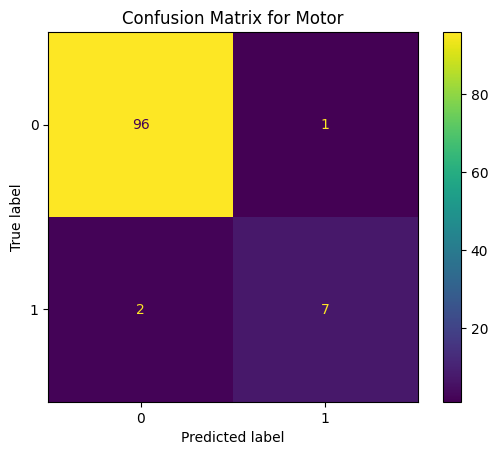

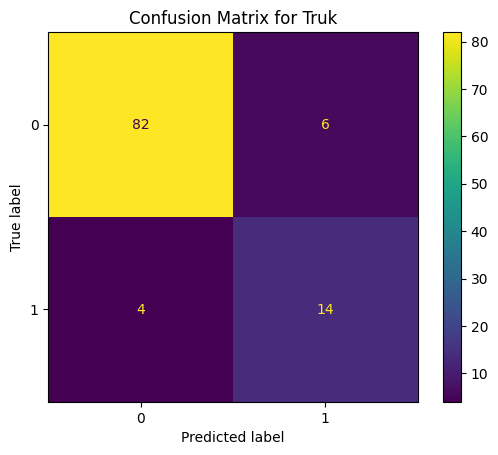

In [56]:
visaul_confusion_matrix(y_true, y_pred_3)

In [57]:
%load_ext tensorboard

In [58]:
%tensorboard --logdir TensorBoard/logs/

### Inception ResnetV2

In [59]:
def inception_resnetv2():
    pre_trainded_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        input_shape = (224, 224, 3),
        include_top = False,
        weights='imagenet'
    )
    
    for layer in pre_trainded_model.layers:
        layer.trainable = False
        
    return pre_trainded_model

In [60]:
inception_resnetv2 = inception_resnetv2()
inception_resnetv2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [61]:
def model_inception_resnetv2(pre_trained_model, last_layer):
    x = tf.keras.layers.Flatten()(last_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    return model

In [62]:
last_layer_inresnetv2 = inception_resnetv2.get_layer("conv_7b_ac")
last_output_inresnetv2 = last_layer_inresnetv2.output


In [63]:
model_inception_resnetv2 = model_inception_resnetv2(inception_resnetv2, last_output_inresnetv2)
model_inception_resnetv2.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)

In [64]:
model_inception_resnetv2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [65]:
with tf.device("/device:GPU:0"):
    history6 = model_inception_resnetv2.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_inception_resnetv2"),
                              myCallback(accuracy=0.95)])

Epoch 1/50
50/50 [==============================] - 17s 163ms/step - loss: 1.8921 - accuracy: 0.8706 - recall: 0.8529 - precision: 0.8407 - f1_score: 0.8188 - val_loss: 0.3020 - val_accuracy: 0.9325 - val_recall: 0.8224 - val_precision: 0.8825 - val_f1_score: 0.8527
Epoch 2/50
50/50 [==============================] - 5s 100ms/step - loss: 0.2434 - accuracy: 0.8668 - recall: 0.8811 - precision: 0.9053 - f1_score: 0.8920 - val_loss: 0.1801 - val_accuracy: 0.9275 - val_recall: 0.8759 - val_precision: 0.9339 - val_f1_score: 0.9036
Epoch 3/50
50/50 [==============================] - 5s 100ms/step - loss: 0.1917 - accuracy: 0.8947 - recall: 0.8950 - precision: 0.9210 - f1_score: 0.9062 - val_loss: 0.1701 - val_accuracy: 0.9400 - val_recall: 0.9002 - val_precision: 0.9332 - val_f1_score: 0.9165
Epoch 4/50
50/50 [==============================] - 5s 100ms/step - loss: 0.1486 - accuracy: 0.9258 - recall: 0.9275 - precision: 0.9328 - f1_score: 0.9313 - val_loss: 0.1667 - val_accuracy: 0.9400 - v

<function matplotlib.pyplot.show(close=None, block=None)>

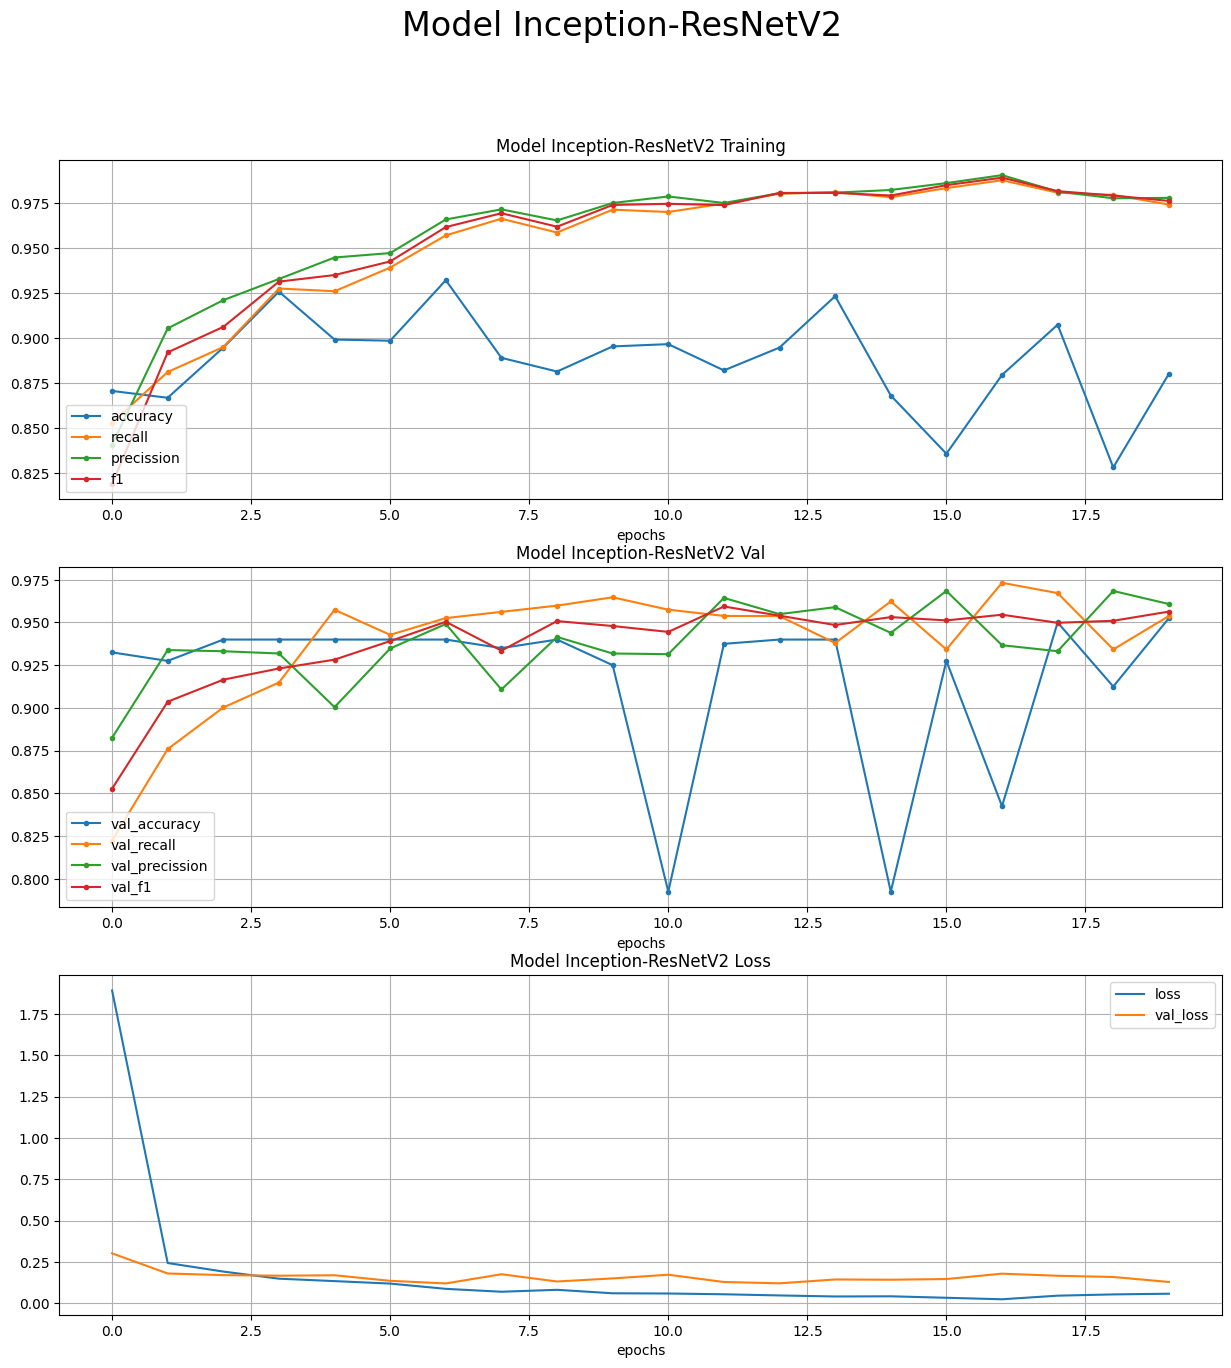

In [66]:
plot_model(history6, "Model Inception-ResNetV2")

In [100]:
model_inception_resnetv2.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 6s 56ms/step - loss: 0.1404 - accuracy: 0.9434 - recall: 0.9387 - precision: 0.9522 - f1_score: 0.9450


[0.14038920402526855,
 0.9433962106704712,
 0.9386792182922363,
 0.9521530866622925,
 0.9449684619903564]

In [67]:
predict(model_inception_resnetv2, "model_inception_resnetv2.csv")
dt_model_inresnetv2 = pd.read_csv("model_inception_resnetv2.csv")
y_pred_6 = dt_model_inresnetv2[["Hewan liar", "Motor", "Kerbau", "Manusia", "Truk"]]

106/106 [==============================] - 7s 38ms/step


[[[101   0]
  [  0   5]]

 [[  1   0]
  [ 97   8]]

 [[  0  31]
  [  0  75]]

 [[ 31  66]
  [  5   4]]

 [[ 82   6]
  [  4  14]]]


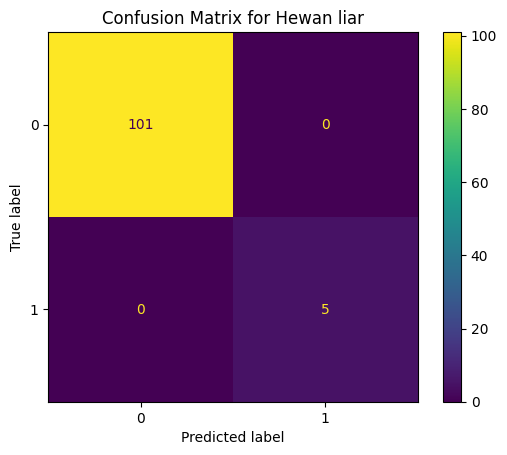

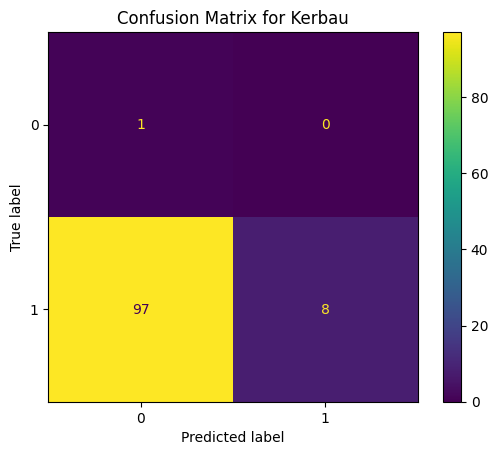

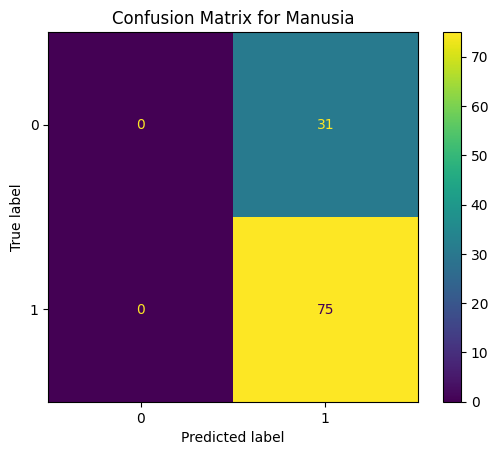

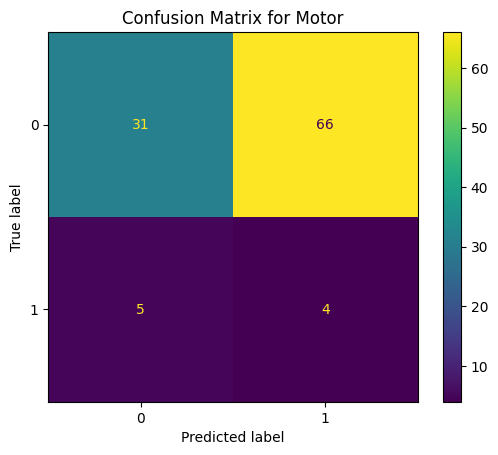

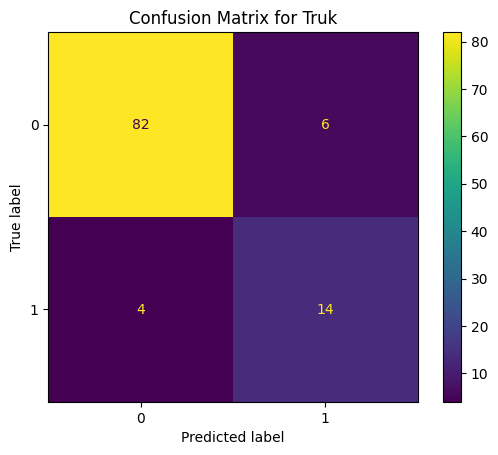

In [68]:
visaul_confusion_matrix(y_true, y_pred_6)

### EfficienNet

In [69]:
def efficienNet():
    pre_trained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    return pre_trained_model

In [70]:
efficienNet = efficienNet()
efficienNet.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [71]:
last_layer_efficientNet = efficienNet.get_layer("top_activation")
last_output_efficientNet = last_layer_efficientNet.output

In [72]:
def final_efficientNet(pre_trained_model, last_layer):
    x = tf.keras.layers.Flatten()(last_layer)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(5, activation="sigmoid")(x)
    
    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)  
    return model

In [73]:
model_efficienNet = final_efficientNet(efficienNet, last_output_efficientNet)
model_efficienNet.compile(optimizer='adam', loss="binary_crossentropy",
                   metrics=metrics)

In [74]:
model_efficienNet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

In [75]:
with tf.device("/device:GPU:0"):
    history5 = model_efficienNet.fit(train_gen,
                              steps_per_epoch=train_gen.n // train_gen.batch_size,
                              epochs=50,
                              validation_data=val_gen,
                              validation_steps=val_gen.n // val_gen.batch_size,
                              callbacks=[tensorboard_callback("model_efficienNetV2S"),
                              myCallback(accuracy=0.95)])

Epoch 1/50
50/50 [==============================] - 19s 159ms/step - loss: 2.9409 - accuracy: 0.9124 - recall: 0.8287 - precision: 0.8153 - f1_score: 0.7878 - val_loss: 0.3652 - val_accuracy: 0.9400 - val_recall: 0.8479 - val_precision: 0.8680 - val_f1_score: 0.8581
Epoch 2/50
50/50 [==============================] - 5s 90ms/step - loss: 0.3425 - accuracy: 0.9499 - recall: 0.8265 - precision: 0.8501 - f1_score: 0.8381 - val_loss: 0.3035 - val_accuracy: 0.9400 - val_recall: 0.8491 - val_precision: 0.8692 - val_f1_score: 0.8590
Epoch 3/50
50/50 [==============================] - 5s 90ms/step - loss: 0.3131 - accuracy: 0.9524 - recall: 0.8264 - precision: 0.8776 - f1_score: 0.8495 - val_loss: 0.2964 - val_accuracy: 0.9400 - val_recall: 0.8502 - val_precision: 0.8682 - val_f1_score: 0.8586
Epoch 4/50
50/50 [==============================] - 5s 90ms/step - loss: 0.3064 - accuracy: 0.9518 - recall: 0.8302 - precision: 0.8763 - f1_score: 0.8533 - val_loss: 0.3083 - val_accuracy: 0.9400 - val_

<function matplotlib.pyplot.show(close=None, block=None)>

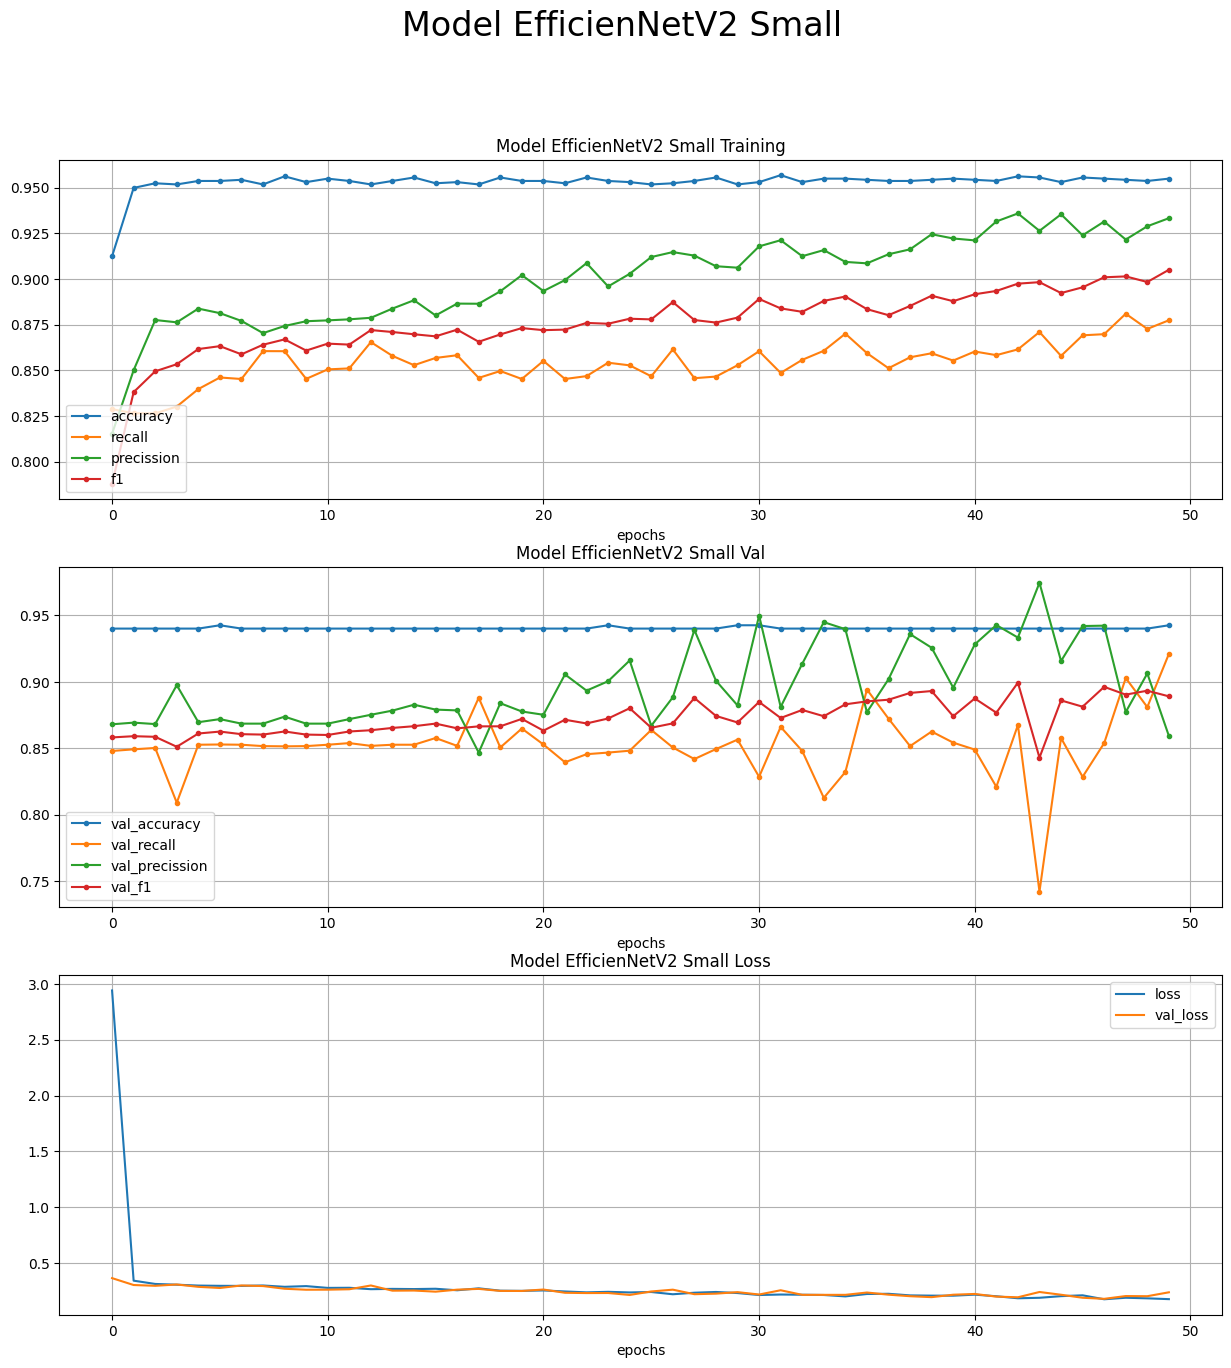

In [76]:
plot_model(history5, "Model EfficienNetV2 Small")

In [101]:
model_efficienNet.evaluate(test_gen, steps=test_gen.n // test_gen.batch_size)

106/106 [==============================] - 6s 57ms/step - loss: 0.2388 - accuracy: 0.9434 - recall: 0.9340 - precision: 0.8571 - f1_score: 0.8969


[0.23875634372234344,
 0.9433962106704712,
 0.9339622855186462,
 0.8571428656578064,
 0.8968554735183716]

In [77]:
predict(model_efficienNet, 'model efficienNet.csv')

106/106 [==============================] - 7s 44ms/step


In [78]:
dt_model_efficenNet = pd.read_csv('model efficienNet.csv')

In [79]:
y_pred_5 = dt_model_efficenNet[["Hewan liar", "Motor", "Kerbau", "Manusia", "Truk"]]

[[[101   0]
  [  2   3]]

 [[  1   0]
  [105   0]]

 [[  0  31]
  [  0  75]]

 [[ 16  81]
  [  0   9]]

 [[ 71  17]
  [  3  15]]]


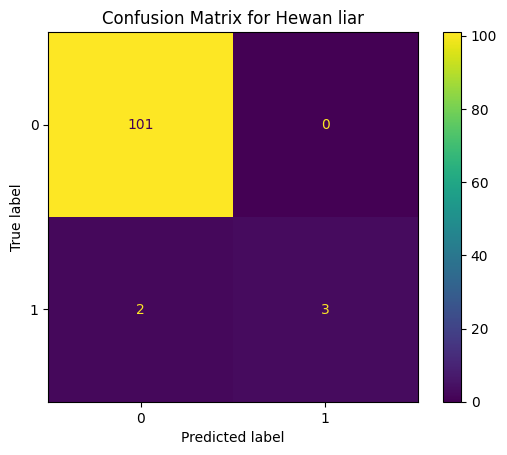

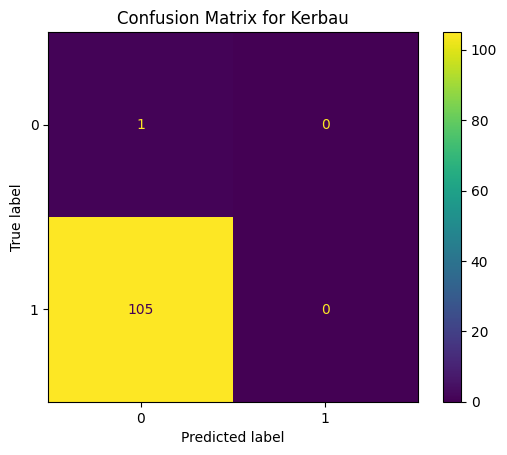

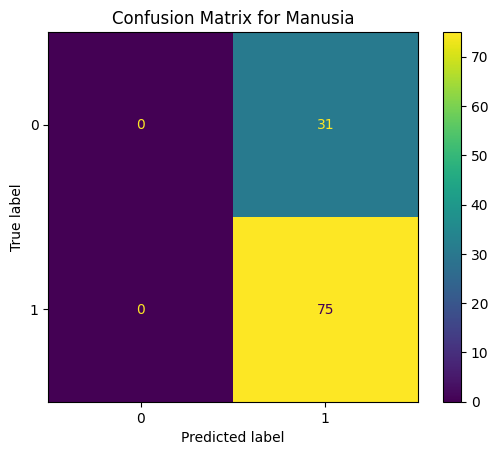

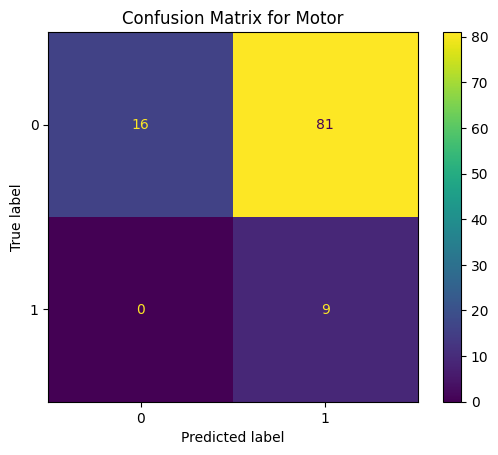

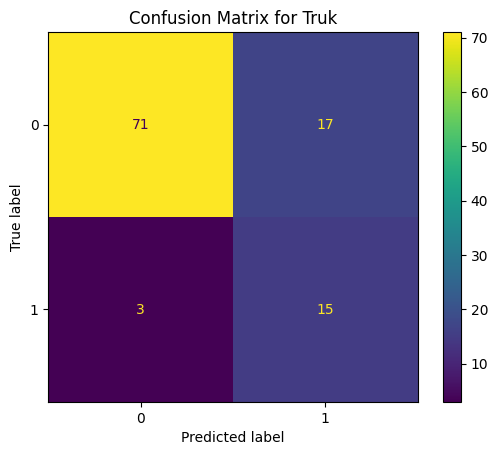

In [80]:
visaul_confusion_matrix(y_true, y_pred_5)

# Define Vis Model

In [81]:
def layer_name(model):
    outputs = [layer.outputs for layer in model.layer]
    layer_name = []
    for layer in outputs:
        layer_name.append(layer.name.split("/"))
    
    return layer_name

In [82]:
def visualize_intermediate_activations(layer_names, activations):
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

In [83]:
predict()

TypeError: predict() missing 2 required positional arguments: 'model' and 'name_file'

In [ ]:
visaul_confusion_matrix()

### Define Grad Cam

In [ ]:
def get_img_array(dir, size):
    img = keras.utils.load_img(dir, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))